In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
import xgboost as xgb

In [3]:
data = pd.read_csv('datasets/PJME_hourly.csv')

In [4]:
data.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [5]:
# Set the 'Datetime' column as the index of the DataFrame 'data'
data = data.set_index('Datetime')

In [6]:
# Convert the current index of the DataFrame 'data' to datetime format
data.index = pd.to_datetime(data.index)

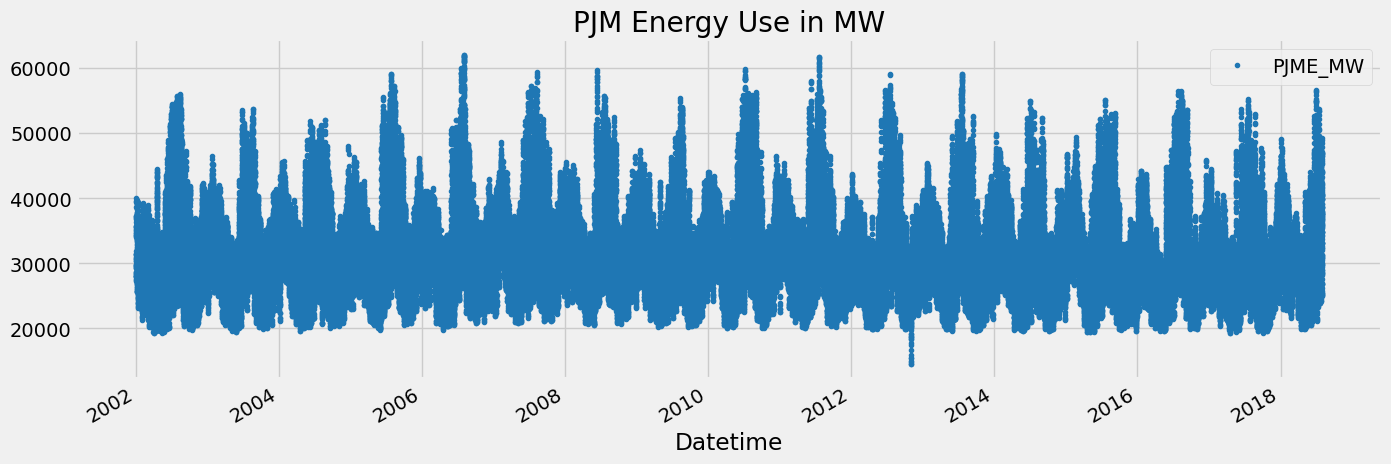

In [7]:
data.plot(style = '.',
          figsize = (15,5),
          color = color_pal[0],
          title = 'PJM Energy Use in MW')

plt.show()

### PJM Energy Use Analysis

This chart depicts the **PJM Energy Use** in megawatts (MW) over time.

The x-axis represents the 'Datetime', showing data from the year 2002 to 2018. The y-axis indicates the energy usage measured in MW. The legend highlights the `PJME_MW` values.

*Key Observations:*

- There is a clear seasonal pattern in energy usage.
- Peak energy usage appears to occur regularly at certain intervals each year.

### Train / Test Split

In [8]:
train = data.loc[data.index < '01-01-2015']
test = data.loc[data.index >= '01-01-2015']

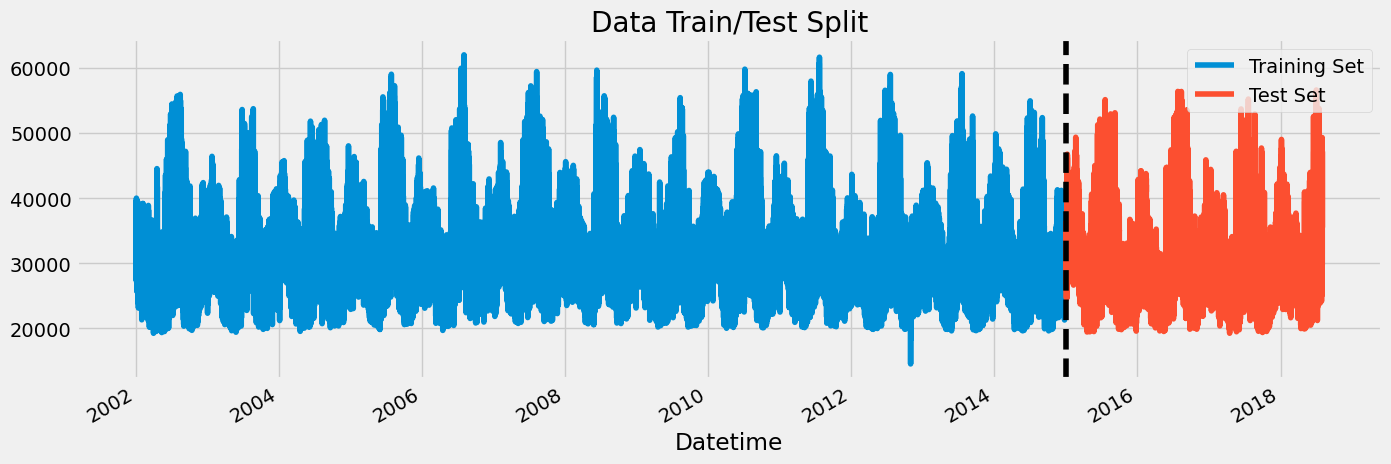

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the training set on the same axis, with label and title
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')

# Plot the test set on the same axis with a label
test.plot(ax=ax, label='Test Set')

# Add a vertical line to indicate the split between train and test data
ax.axvline('01-01-2015', color='black', ls='--')

# Add a legend to distinguish between the training and test sets
ax.legend(['Training Set', 'Test Set'])

plt.show()

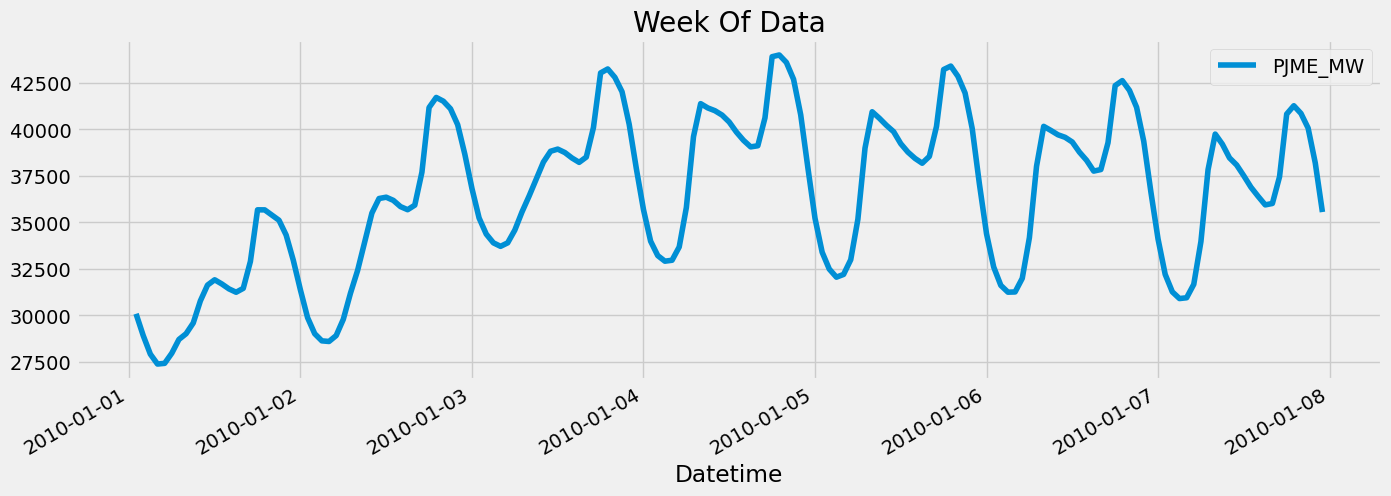

In [10]:
# Filter the data for the specified date range and plot it
data.loc[(data.index > '01-01-2010') & (data.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')

plt.show()

### Week of Energy Usage Data

This chart illustrates the **PJM Energy Use** in megawatts (MW) over a specific week in January 2010.

*Description:*

- **Date Range:** January 1, 2010 to January 8, 2010
- The line represents daily energy consumption.
- Observations show fluctuations in energy use, with noticeable peaks and troughs throughout the week.

### Feature Creation

In [11]:
def create_features(data):
    """
    Create time series features based on time series index.
    """
    data = data.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['dayofyear'] = data.index.dayofyear
    data['dayofmonth'] = data.index.day
    data['weekofyear'] = data.index.isocalendar().week
    return data

data = create_features(data)

### Visualize our Feature / Target Relationship

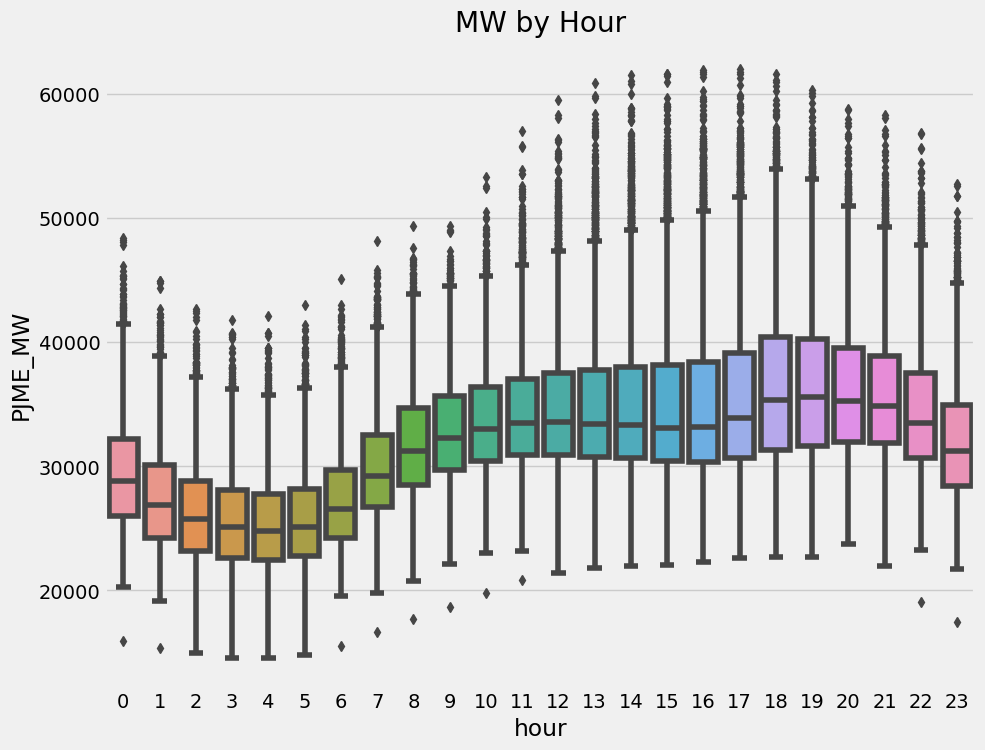

In [12]:
fig, ax = plt.subplots(figsize = (10, 8))

sns.boxplot(data = data, x = 'hour', y = 'PJME_MW')
ax.set_title('MW by Hour')

plt.show()

### Hourly Energy Usage Distribution

This box plot illustrates the distribution of **PJM Energy Use** in megawatts (MW) across each hour of the day.

*Description:*

- The x-axis represents the hour of the day (0 to 23).
- The y-axis shows the energy usage in MW.
- Each boxplot summarizes the distribution of energy usage for a specific hour, highlighting the median, quartiles, and outliers.
- Noticeable variations in energy consumption can be observed at different times, with higher usage during late afternoon and early evening.

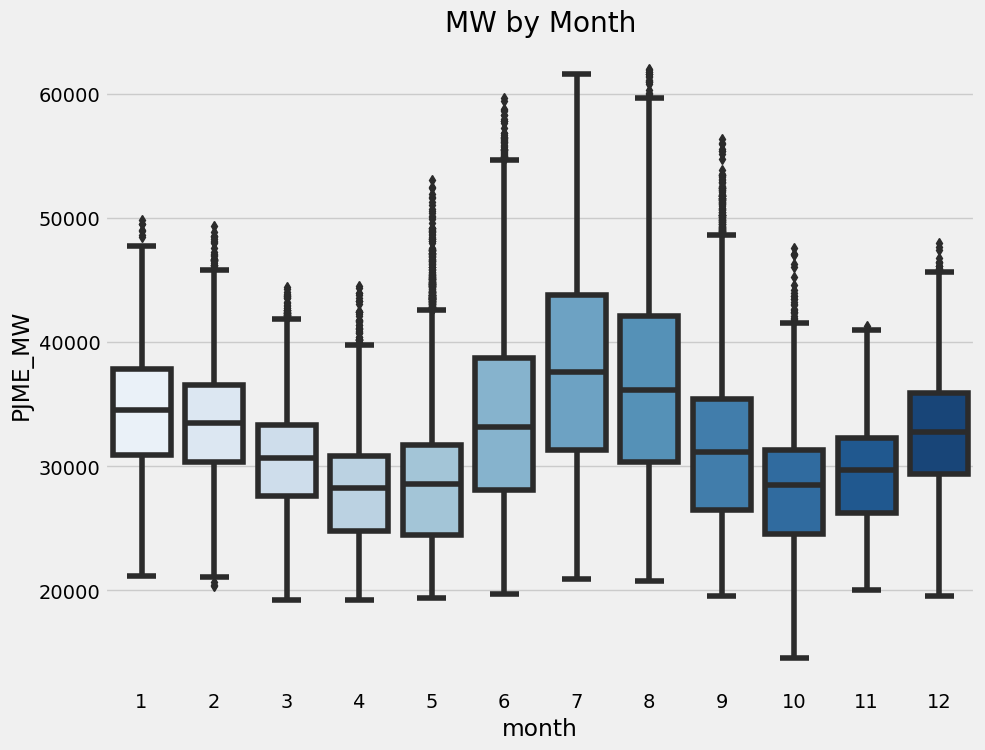

In [13]:
fig, ax = plt.subplots(figsize = (10, 8))

sns.boxplot(data = data, x = 'month', y = 'PJME_MW', palette = 'Blues')
ax.set_title('MW by Month')

plt.show()

### Monthly Energy Usage Distribution

This box plot shows the distribution of **PJM Energy Use** in megawatts (MW) for each month of the year.

*Description:*

- The x-axis represents the months of the year (1 to 12).
- The y-axis shows the energy usage in MW.
- Each boxplot provides a summary of the energy usage distribution for each month, highlighting the median, quartiles, and outliers.
- Notable variations in energy consumption across different months are apparent, with some months exhibiting higher median usage.

### Create our Model

In [14]:
# Apply the feature creation function to both train and test datasets
train = create_features(train)
test = create_features(test)

# Define the features to be used for the model
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']

# Define the target variable
TARGET = 'PJME_MW'

# Extract the features and target from the training data
X_train = train[FEATURES]
y_train = train[TARGET]

# Extract the features and target from the test data
X_test = test[FEATURES]
y_test = test[TARGET]

In [15]:
# Initialize an XGBoost Regressor with specified parameters
reg = xgb.XGBRegressor(
    base_score=0.5,           # Initial prediction score
    booster='gbtree',         # Type of booster to use
    n_estimators=1000,        # Number of trees in the ensemble
    early_stopping_rounds=50, # Stop training if no improvement after 50 rounds
    objective='reg:linear',   # Objective function for linear regression
    max_depth=3,              # Maximum depth of each tree
    learning_rate=0.01        # Step size for updating weights
)

# Fit the model using training data
reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)], # Evaluation sets for monitoring training
    verbose=100                # Print progress every 100 rounds
)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


/Users/ramanujsharma/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:19:29] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.94591


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

### Feature Importance

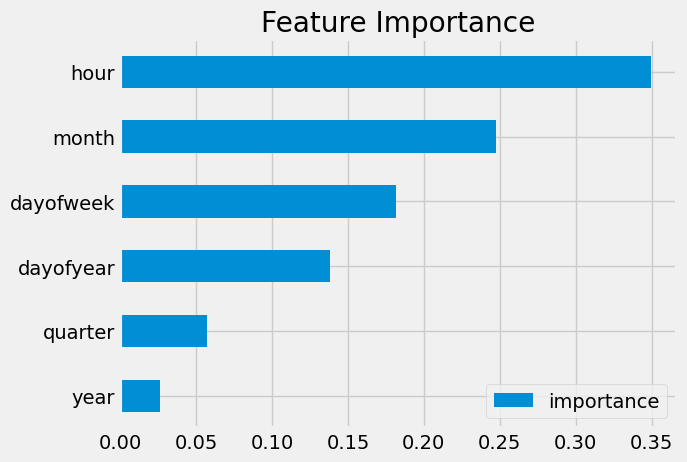

In [16]:
fi = pd.DataFrame(data = reg.feature_importances_,
             index = reg.feature_names_in_,
             columns = ['importance'])

fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')
plt.show()

### Feature Importance Analysis

This bar chart illustrates the importance of different features in predicting **PJM Energy Use**.

*Description:*

- **hour**: Most significant feature, indicating strong influence on energy usage predictions.
- **month** and **dayofweek**: Also contribute significantly, reflecting seasonal and weekly patterns.
- Other features like **dayofyear**, **quarter**, and **year** have less impact but still play a role.
- This analysis helps focus on key variables for improving model accuracy.

### Forecast on Test

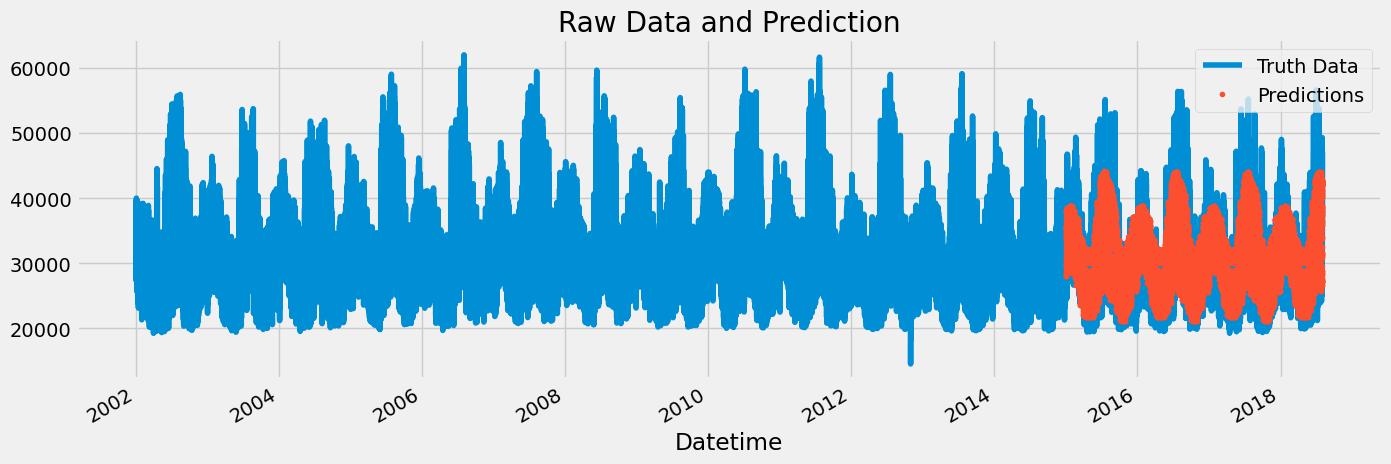

In [17]:
# Make predictions on the test data using the trained model
test['prediction'] = reg.predict(X_test)

# Merge the predictions back into the original data for comparison
data = data.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# Plot the true energy usage data
ax = data[['PJME_MW']].plot(figsize=(15, 5))

# Plot the predicted energy usage on the same axis
data['prediction'].plot(ax=ax, style='.')

# Add a legend to distinguish true data from predictions
plt.legend(['Truth Data', 'Predictions'])

ax.set_title('Raw Data and Prediction')

plt.show()

### Raw Data and Prediction Comparison

This chart compares the actual **PJM Energy Use** data with the model's predictions.

*Description:*

- **Truth Data** (in blue) represents the actual energy usage from 2002 to 2018.
- **Predictions** (in red) overlay the observed data where predictions were made.
- The visualization helps assess the model's performance by comparing predicted values against actual data.
- Notice the alignment and deviations between the predicted and true values, highlighting areas for potential model refinement.

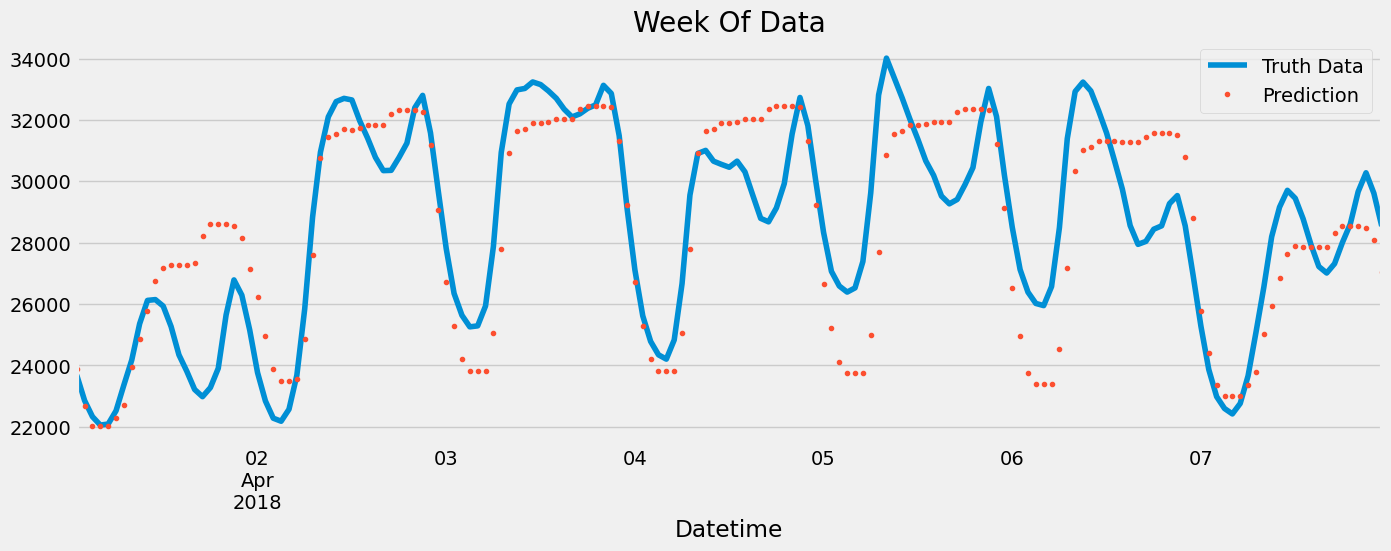

In [18]:
# Plot the true energy usage data for a specific week in April 2018
ax = data.loc[(data.index > '04-01-2018') & (data.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')

# Plot the predicted energy usage for the same week on the same axis
data.loc[(data.index > '04-01-2018') & (data.index < '04-08-2018')]['prediction'] \
    .plot(style='.')

# Add a legend to distinguish between true data and predictions
plt.legend(['Truth Data', 'Prediction'])

plt.show()

### Weekly Data Comparison

This chart shows the actual and predicted **PJM Energy Use** for the week of April 1, 2018, to April 8, 2018.

*Description:*

- **Truth Data** (blue line) depicts actual energy usage.
- **Prediction** (red dots) indicates the model's predictions for the same period.
- The visualization helps to assess the accuracy of the model at a finer time scale.
- Observe how closely the predictions follow the true data, highlighting areas of strong and weak predictive performance.

### Score (RMSE)

In [19]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3726.80


### Calculate Error

In [20]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12879.484619
2016-08-14    12772.887207
2015-02-20    11186.031494
2016-09-09    10966.513102
2016-09-10    10889.102214
2018-01-06    10642.975830
2016-08-12    10041.172689
2015-02-21     9988.168783
2015-02-16     9900.809326
2018-01-07     9852.571370
Name: error, dtype: float64

### Model Performance and Error Analysis

The RMSE score indicates the average deviation of the predicted values from the actual values. An RMSE of **3726.80** suggests a reasonable level of accuracy, but there might be room for improvement in model precision or further tuning parameters.

#### Observation:
The dates with the highest prediction error mostly occur during specific months, potentially indicating seasonal effects or anomalous events affecting energy consumption. This pattern suggests:

- **Summer Mid-August Peaks:** Several high error days in mid-August may point to erratic usage patterns possibly due to heat waves or other regional factors affecting energy demand.
- **Winter Anomalies:** Early January and late February also show significant errors, which could be attributed to unpredictable weather or changes in energy usage patterns during the winter months.

A deeper exploration of these dates might provide insights for refining the model, such as incorporating additional features to capture these seasonal or anomalous influences more effectively.

### Outlier Analysis and removal

<AxesSubplot:ylabel='Frequency'>

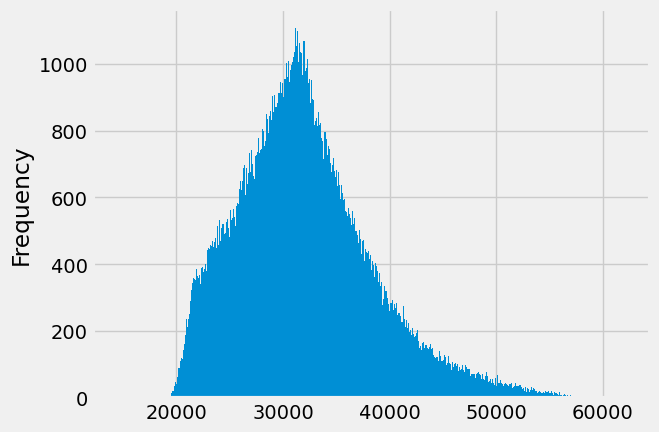

In [21]:
data['PJME_MW'].plot(kind='hist', bins=500)

### Distribution of Energy Usage

This histogram illustrates the distribution of **PJM Energy Use** in megawatts (MW).

*Description:*

- The x-axis represents energy usage in MW.
- The y-axis indicates the frequency or count of occurrences.
- The histogram shows a peak around 30,000 MW, indicating this is the most common level of energy usage.
- There is a skew towards lower usage values, with a gradual decline as usage increases.

<AxesSubplot:title={'center':'Outliers'}, xlabel='Datetime'>

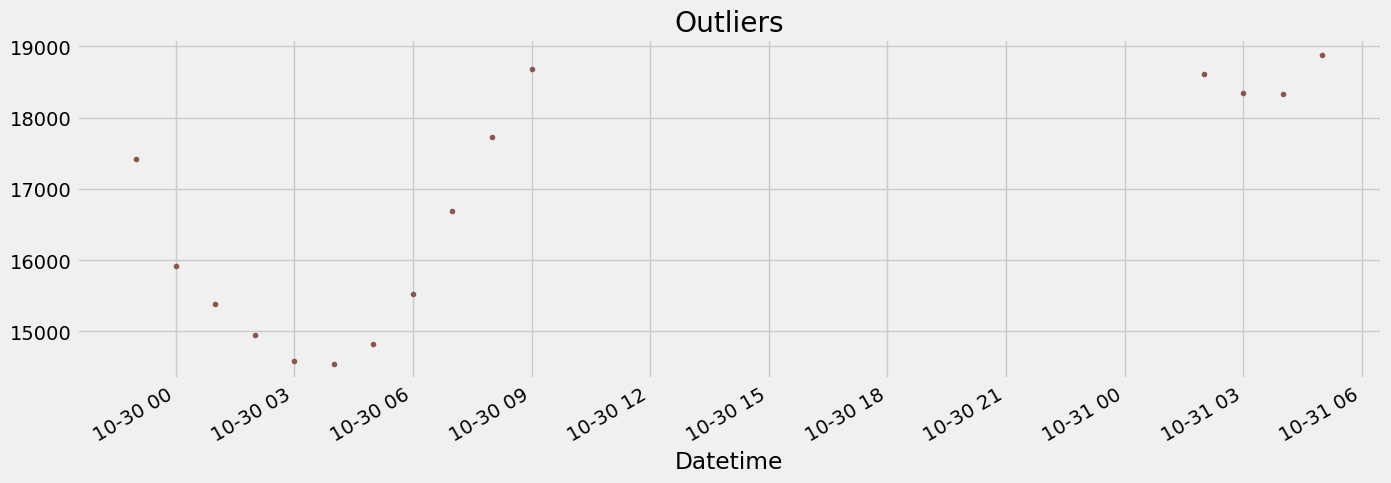

In [22]:
data.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

### Outlier Detection

This scatter plot highlights the outliers in **PJM Energy Use** over a specific time period.

*Description:*

- The x-axis represents the datetime, focusing on October 30-31.
- The y-axis shows energy usage values that are considered outliers.
- Outliers are points that deviate significantly from the rest of the data, indicating potential anomalies or data entry errors.
- Identifying outliers helps in understanding unusual patterns and ensuring data quality.

In [23]:
data = data.query('PJME_MW > 19_000').copy()

### Reviewing: Train / Test Split

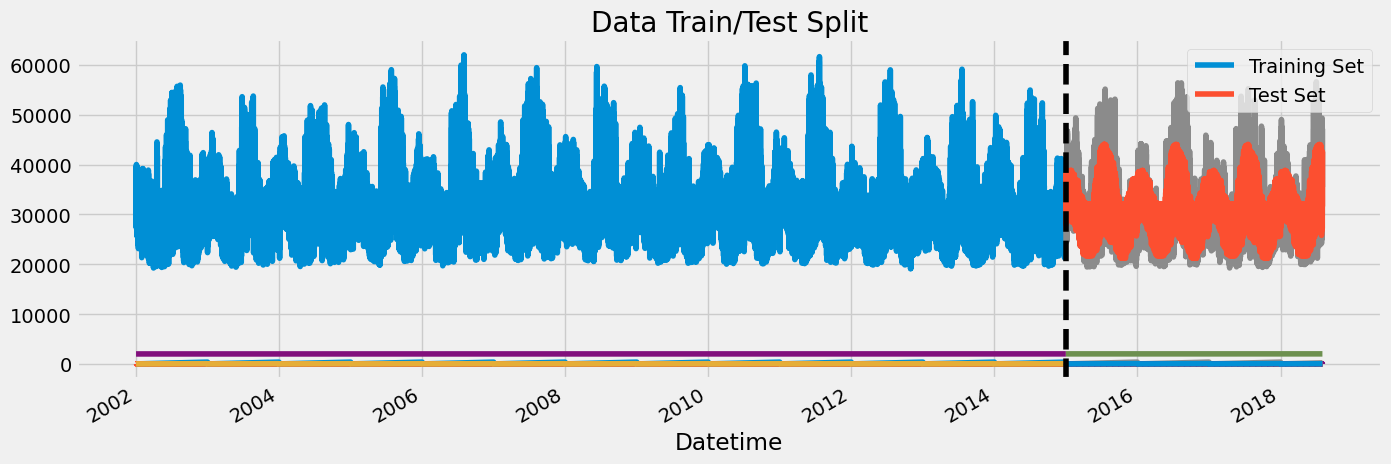

In [24]:
train = data.loc[data.index < '01-01-2015']
test = data.loc[data.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### Data Train/Test Split

This plot visualizes the division between the training and test datasets for **PJM Energy Use**.

*Description:*

- The blue section represents the **Training Set**, covering data from 2002 to early 2015.
- The red section indicates the **Test Set**, spanning data from 2015 onwards.
- A vertical dashed line marks the split point between training and testing data.
- This separation is crucial for evaluating the model's performance on unseen data, helping ensure the model's predictive capability and generalization.

### Time Series Cross Validation

In [25]:
# Initialize a TimeSeriesSplit object for cross-validation
tss = TimeSeriesSplit(
    n_splits=5,          # Number of re-shuffling & splitting iterations
    test_size=24*365*1,  # Size of the test set (1 year, assuming hourly data)
    gap=24               # Gap between train and test sets to avoid leakage
)

# Ensure the data is sorted by index (typically datetime) for time series analysis
data = data.sort_index()

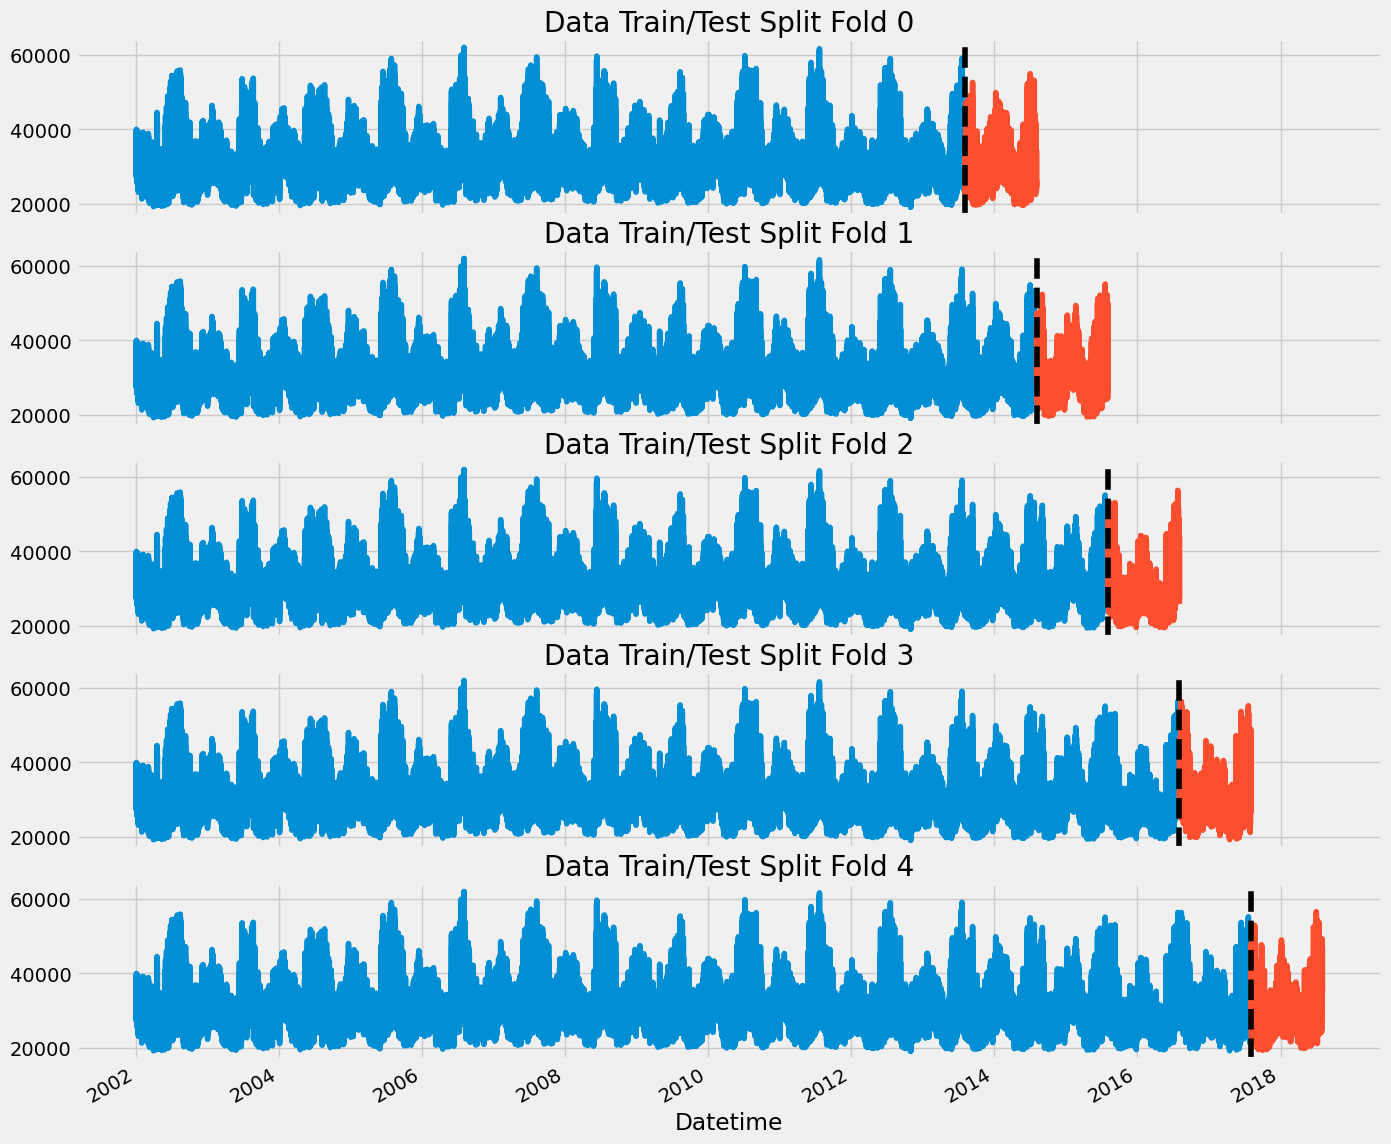

In [26]:
# Create subplots with 5 rows, 1 column, shared x-axis, and specified figure size
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

# Initialize fold counter
fold = 0

# Iterate over each train/test split
for train_idx, val_idx in tss.split(data):
    # Get the training and test data for the current split
    train = data.iloc[train_idx]
    test = data.iloc[val_idx]
    
    # Plot the training set
    train['PJME_MW'].plot(
        ax=axs[fold],
        label='Training Set',
        title=f'Data Train/Test Split Fold {fold}'
    )
    
    # Plot the test set
    test['PJME_MW'].plot(
        ax=axs[fold],
        label='Test Set'
    )
    
    # Draw a vertical line at the start of the test set
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    
    # Increment fold counter
    fold += 1

plt.show()

# Data Train/Test Splits Across Folds

This visualization shows the train/test splits for each fold in a time series cross-validation setup.

*Description:*

- Each subplot corresponds to one of the five folds.
- **Training Set** (blue): Represents the data used for training the model.
- **Test Set** (red): Represents the data used for testing the model.
- The vertical dashed line marks the boundary between training and test sets.
- This approach helps evaluate the model's performance and robustness across different segments of the dataset.

### Lag Features

In [27]:
def add_lags(data):
    # Create a dictionary for fast lookup of PJME_MW values by index
    target_map = data['PJME_MW'].to_dict()
    
    # Create a lag feature for 1 year ago
    data['lag1'] = (data.index - pd.Timedelta('364 days')).map(target_map)
    
    # Create a lag feature for 2 years ago
    data['lag2'] = (data.index - pd.Timedelta('728 days')).map(target_map)
    
    # Create a lag feature for 3 years ago
    data['lag3'] = (data.index - pd.Timedelta('1092 days')).map(target_map)
    
    return data

In [28]:
data = add_lags(data)

### Train Using Cross Validation

In [29]:
# Initialize a time series split for cross-validation with 5 splits
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)

# Sort the data by index to ensure sequential order
data = data.sort_index()

# Initialize fold counter, prediction storage, and score storage
fold = 0
preds = []
scores = []

# Loop through each train/test split
for train_idx, val_idx in tss.split(data):
    # Split data into training and test sets based on indices
    train = data.iloc[train_idx]
    test = data.iloc[val_idx]

    # Create time series features for train and test sets
    train = create_features(train)
    test = create_features(test)

    # Define features and target for the model
    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
                'lag1', 'lag2', 'lag3']
    TARGET = 'PJME_MW'

    # Extract features and target for training
    X_train = train[FEATURES]
    y_train = train[TARGET]

    # Extract features and target for testing
    X_test = test[FEATURES]
    y_test = test[TARGET]

    # Initialize the XGBoost Regressor with specified parameters
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)

    # Fit the model on the training data
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    # Predict the target variable on the test set
    y_pred = reg.predict(X_test)

    # Append predictions and score for current fold
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.29813	validation_1-rmse:31956.12901


/Users/ramanujsharma/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:19:47] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.43235	validation_1-rmse:11904.58782
[200]	validation_0-rmse:5744.95222	validation_1-rmse:5356.84300
[300]	validation_0-rmse:3871.90369	validation_1-rmse:3892.59716
[400]	validation_0-rmse:3435.02956	validation_1-rmse:3754.33238
[445]	validation_0-rmse:3365.94502	validation_1-rmse:3757.55814
[0]	validation_0-rmse:32671.76899	validation_1-rmse:32142.13679


/Users/ramanujsharma/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:19:50] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.53851	validation_1-rmse:12226.39459
[200]	validation_0-rmse:5755.01846	validation_1-rmse:5651.27874
[300]	validation_0-rmse:3906.82210	validation_1-rmse:3927.45255
[400]	validation_0-rmse:3478.17872	validation_1-rmse:3596.84442
[500]	validation_0-rmse:3352.66618	validation_1-rmse:3523.07822
[600]	validation_0-rmse:3296.70510	validation_1-rmse:3487.82916
[700]	validation_0-rmse:3257.73321	validation_1-rmse:3468.06020
[800]	validation_0-rmse:3222.25681	validation_1-rmse:3445.37604
[900]	validation_0-rmse:3192.52469	validation_1-rmse:3432.72311
[999]	validation_0-rmse:3165.63907	validation_1-rmse:3425.71868
[0]	validation_0-rmse:32630.97735	validation_1-rmse:31069.98153


/Users/ramanujsharma/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:19:56] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12498.81929	validation_1-rmse:11133.77575
[200]	validation_0-rmse:5749.69417	validation_1-rmse:4808.52984
[300]	validation_0-rmse:3914.33408	validation_1-rmse:3542.09733
[400]	validation_0-rmse:3492.92067	validation_1-rmse:3488.41143
[402]	validation_0-rmse:3489.21578	validation_1-rmse:3490.11888
[0]	validation_0-rmse:32528.18588	validation_1-rmse:31474.51358


/Users/ramanujsharma/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:19:59] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.18076	validation_1-rmse:12018.20453
[200]	validation_0-rmse:5737.83720	validation_1-rmse:5794.21490
[300]	validation_0-rmse:3914.73269	validation_1-rmse:4385.31167
[400]	validation_0-rmse:3497.45006	validation_1-rmse:4169.33613
[500]	validation_0-rmse:3382.37925	validation_1-rmse:4114.28118
[600]	validation_0-rmse:3323.85812	validation_1-rmse:4100.91700
[700]	validation_0-rmse:3282.58032	validation_1-rmse:4088.30188
[771]	validation_0-rmse:3258.52054	validation_1-rmse:4084.42225
[0]	validation_0-rmse:32461.76096	validation_1-rmse:31462.58329


/Users/ramanujsharma/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:20:04] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.41304	validation_1-rmse:11962.08478
[200]	validation_0-rmse:5751.81541	validation_1-rmse:5613.52924
[300]	validation_0-rmse:3951.49944	validation_1-rmse:4150.62570
[400]	validation_0-rmse:3540.50262	validation_1-rmse:4001.62992
[439]	validation_0-rmse:3482.16787	validation_1-rmse:4003.54837


In [30]:
# The cross-validation results provide insights into the model's performance across different data splits.

# This value represents the mean RMSE (Root Mean Square Error) across all folds, indicating the overall predictive accuracy of the model.
print(f'Score across folds {np.mean(scores):0.4f}')

# These individual fold scores highlight variability in model performance, suggesting areas for potential tuning or adjustment.
print(f'Fold scores:{scores}')

Score across folds 3746.8788
Fold scores:[3753.6176552727843, 3425.271376428151, 3473.313333085868, 4083.6723271785127, 3998.5195052083054]


### Predicting the Future

In [31]:
# Add time series features to the entire dataset
data = create_features(data)

# Define the features to be used for the model
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1', 'lag2', 'lag3']

# Define the target variable
TARGET = 'PJME_MW'

# Extract the features and target from the entire dataset
X_all = data[FEATURES]
y_all = data[TARGET]

# Initialize the XGBoost Regressor with specified parameters for the final model
reg = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=500,      # Reduced number of estimators for final training
    objective='reg:linear',
    max_depth=3,
    learning_rate=0.01
)

# Fit the model on the entire dataset to make the final predictions
reg.fit(
    X_all, y_all,
    eval_set=[(X_all, y_all)],
    verbose=100  # Print progress every 100 rounds
)

[0]	validation_0-rmse:32403.50092


/Users/ramanujsharma/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:20:08] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.68377
[200]	validation_0-rmse:5752.98750
[300]	validation_0-rmse:3972.52175
[400]	validation_0-rmse:3572.64777
[499]	validation_0-rmse:3458.28412


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [32]:
data.index.max()

Timestamp('2018-08-03 00:00:00')

In [33]:
# Create a date range for future predictions from August 3, 2018, to August 1, 2019, with hourly frequency
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')

# Initialize a DataFrame with the future dates as the index
future_data = pd.DataFrame(index=future)

# Mark the future data with a new column
future_data['isFuture'] = True

# Mark existing data as not future
data['isFuture'] = False

# Concatenate existing data with future data
data_and_future = pd.concat([data, future_data])

# Add time series features to the combined dataset
data_and_future = create_features(data_and_future)

# Add lag features to the combined dataset
data_and_future = add_lags(data_and_future)

In [34]:
future_w_features = data_and_future.query('isFuture').copy()

### Predict the future

In [35]:
# Use the trained model to predict future energy usage based on the specified features
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

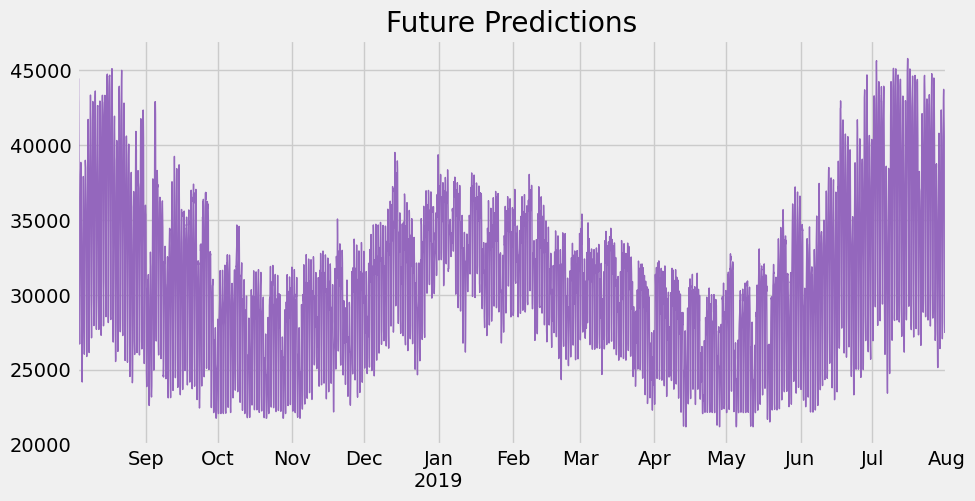

In [36]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

### Future Energy Usage Predictions

This line chart visualizes the predicted **PJM Energy Use** from August 2018 to August 2019.

*Description:*

- The x-axis represents the months from August 2018 to August 2019.
- The y-axis shows the predicted energy usage in megawatts (MW).
- The purple line illustrates the model's predictions, capturing seasonal trends and variations throughout the year.
- Notable peaks and troughs indicate expected changes in energy demand during different seasons.

These predictions can be used for planning and resource allocation in energy management.

In [37]:
# Save the trained model to a file in JSON format
reg.save_model('model.json')

Saving the model allows you to persist the trained model for future use. You can load the model later to make predictions on new data without needing to retrain it, saving time and computational resources. This is especially useful for deploying the model in production environments.

In [38]:
!ls -lh

total 4320
-rw-r--r--@  1 ramanujsharma  staff    28B Mar  5 13:12 README.md
drwx------@ 16 ramanujsharma  staff   512B Mar  5 13:32 datasets
-rw-r--r--@  1 ramanujsharma  staff   559K Mar  5 21:20 model.json
-rwx------@  1 ramanujsharma  staff   1.5M Mar  5 21:19 time_series_forecasting.ipynb


<AxesSubplot:title={'center':'Future Predictions'}>

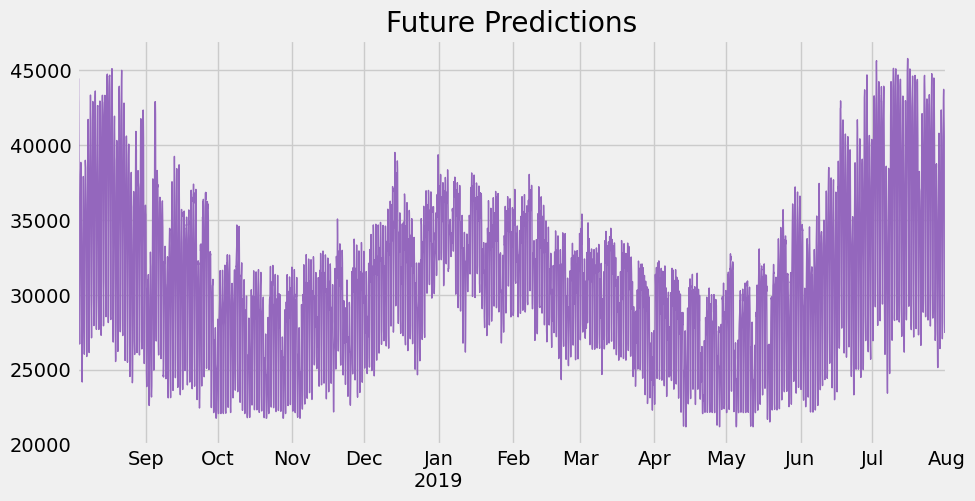

In [39]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')

### Future Energy Usage Predictions

This chart illustrates predicted **PJM Energy Use** from August 2018 to August 2019.

*Description:*

- The x-axis spans from August 2018 to August 2019, showing monthly intervals.
- The y-axis displays the predicted energy usage in megawatts (MW).
- The purple line represents the model's predictions, reflecting seasonal trends throughout the year.
- The chart shows variations in energy demand, with higher usage expected during peak seasons.

These predictions aid in understanding potential future energy demands and planning resource allocation.

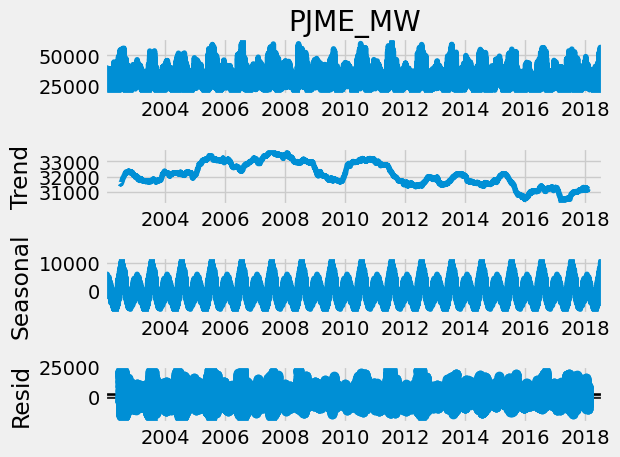

In [40]:
# Perform seasonal decomposition
result = seasonal_decompose(data['PJME_MW'], model='additive', period=24*365)

# Plot the decomposed components
result.plot()
plt.show()

### Time Series Decomposition of PJME_MW

This visualization presents the decomposition of the **PJM Energy Use** time series into its components.

*Components:*

1. **Original Series (PJME_MW):** Displays the overall energy usage over time.
2. **Trend:** Highlights the long-term movement and shifts in energy consumption patterns.
3. **Seasonal:** Shows repeating patterns or cycles, indicating regular fluctuations within the data.
4. **Residual (Resid):** Represents the noise or random variations remaining after removing the trend and seasonality.

This decomposition helps in understanding underlying patterns and informing model development for forecasting.